# Twitter Sentiment Analysis

This notebook aims to analyze Tweets made about the COVID-19 vaccine and determine whether the sentiment of the Tweets is negative, positive, or neutral.

## Libraries

In [1]:
import tweepy
import webbrowser
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import time

import config
pd.set_option('display.max_colwidth', None)

from tweepy import OAuthHandler
from tweepy import API

import os
from google.oauth2 import service_account
from google.cloud import translate_v2 as translate
from google.cloud import language

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import FreqDist
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk import word_tokenize, TweetTokenizer, FreqDist
import string

import re
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Gather data from Twitter API

In [ ]:
# Developer API keys
# API keys in config.py in .gitignore
callback_uri = 'oob'

In [ ]:
auth = OAuthHandler(config.consumer_key, config.consumer_secret, callback_uri)
auth.set_access_token(config.access_token, config.access_token_secret)

In [ ]:
api = API(auth, wait_on_rate_limit= True, wait_on_rate_limit_notify= True)

In [ ]:
# show my Twitter handle
me = api.me()
print(me.screen_name)

In [ ]:
# simple query to get the hang of it
query = '#vaccine covid -RT -@ -http'
for i, status in enumerate(tweepy.Cursor(api.search, q= query).items(15)):
    print (i, status.text)

# filter only English tweets    
# query = '#vaccine covid'
# for i, status in enumerate(tweepy.Cursor(api.search, q= query, lang= 'en').items(50)):
#     print (i, status.text)

In [ ]:
''' This cell was run to collect the initial 5000 tweets and save them to a csv file
is commented out to prevent it from being run again


# collect 5000 tweets 
number_of_tweets = 5000
tweets = []
language = []
time = []

# only collect full text, language, and time it was posted
# remove any retweets '-RT'
for i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  
                       tweet_mode = 'extended').items(number_of_tweets):
    tweets.append(i.full_text)
    language.append(i.lang)
    time.append(i.created_at)

# turn tweets / lists into dataframe
df = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})

# save df to csv
df.to_csv('data/tweets.csv', index= False)
'''

Collect more tweets after waiting to avoid collecting the same tweets.

In [ ]:
# create function to get more tweets and add to existing csv
def get_more_tweets(num_tweets):
    number_of_tweets = num_tweets
    tweets = []
    language = []
    time = []

    # only collect full text, language, and time it was posted
    # remove any retweets '-RT'
    for i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  
                           tweet_mode = 'extended').items(number_of_tweets):
        tweets.append(i.full_text)
        language.append(i.lang)
        time.append(i.created_at)
        
    # turn tweets / lists into dataframe
    df = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})
    
    # add to existing csv file
    df.to_csv('data/tweets.csv', mode= 'a', index= False, header= False)

In [ ]:
# get tweets and save to csv through function

# n_tweets = 20
# get_more_tweets(n_tweets)

### Search for Tweets from 30 Days Ago

In [ ]:
# function to turn results into DataFrame
def extract_text_as_df(text_list):
    columns = set()
    allowed_types = [str, int]
    tweets_data = []
    for status in text_list:
        status_dict = dict(vars(status))
        keys = status_dict.keys()
        single_tweet_data = {"author": status.author.screen_name}
        for k in keys:
            try:
                v_type = type(status_dict[k])
            except:
                v_type = None
            if v_type != None:
                if v_type in allowed_types:
                    single_tweet_data[k] = status_dict[k]
                    columns.add(k)
        tweets_data.append(single_tweet_data)


    header_cols = list(columns)
    header_cols.append('author')
    df = pd.DataFrame(tweets_data, columns=header_cols)
    return df

In [ ]:
query = 'vaccine covid -RT'
results_30 = api.search_30_day('datacollection', query, maxResults= 100)

In [ ]:
old_results_df = extract_text_as_df(results_30)

In [ ]:
old_results_df

## Data Cleaning & EDA

In [ ]:
df = pd.read_csv('data/tweets.csv')

In [ ]:
df.info()

### Check and Remove Duplicates

In [ ]:
# check for duplicated tweets
duped = df[df.duplicated(subset= 'tweets')]
duped.info()

In [ ]:
# remove duplicates
df.drop_duplicates(subset= 'tweets', keep= 'first', inplace= True)
df.reset_index(drop= True, inplace= True)

# make sure they are gone
df.tweets.duplicated().sum()

In [ ]:
df.head(15)

### Looking at Languages

In [ ]:
lang_df = df.sort_values('language')

In [ ]:
plt.figure(figsize= (12, 8))
lang_df.language.value_counts(normalize=True).plot(kind= 'barh')
plt.title('Proportion of Languages Collected')
plt.xlim(-.01, 1)
plt.show()

In [ ]:
lang_df.language.value_counts(normalize=True)

In [ ]:
# what are these languages? get table from url
URL = 'https://developer.twitter.com/en/docs/twitter-for-websites/supported-languages'
tables = pd.read_html(URL)
print("There are : ",len(tables)," tables")
print(tables[0])

lang_table = tables[0]

In [ ]:
# format table
header_row = 0
lang_table.columns = lang_table.iloc[header_row]
lang_table = lang_table.drop(header_row)
lang_table.reset_index(drop= True, inplace= True)

lang_table.replace('English (default)', 'English', inplace= True)
# lang_table

In [ ]:
# save as csv in data folder
lang_table.to_csv('data/languages.csv', index= False)

In [ ]:
# look at 'und' language 
df[df['language'] == 'und']

It appears that the 'und' or possibly 'undetermined' language are tweets that do not include text to help us with our sentiment analysis. We will remove those from our DataFrame.

In [ ]:
df = df[df['language'] != 'und']
# df.info()

Merge the data with the languages to see the whole name of languages

In [ ]:
# merge data with language names
df2 = df.merge(lang_table, how= 'inner', left_on= 'language', right_on= 'Language code')
df2.info()

In [ ]:
# drop extra columns and rename them and change dates to datetime and drop time
df2.drop(columns = ['language', 'Language code'], inplace= True)
df2.rename(columns={'Name': 'language'}, inplace= True)
df2['time'] = pd.to_datetime(df2['time']).dt.date
# df2

Let's see how many Tweets are in each language?

In [ ]:
sns.countplot(y= 'language', data= df2)

The majority of Tweets are in English. Let's see what the other languages are.

In [ ]:
# countplot that excludes English to see detail
plt.figure(figsize= (10, 8))
sns.countplot(y= 'language', data= df2, palette='plasma',
              order= df2.language.value_counts().iloc[1:].index)
plt.title('Count of Tweets, Excluding English', fontsize= 14)
plt.xlabel('# of Tweets')
plt.ylabel('Language')
plt.show()

After English, the top 3 languages for Tweets about the COVID-19 vaccine are in French, Spanish, and Japanese.

In [ ]:
df2.head(10)

#### Translate to English using Google Cloud Platform's API

**Most of this section has been commented out to prevent running on Google Cloud.**

In [ ]:
# send in credentials that are saved on local computer
credentials = service_account.Credentials.from_service_account_file('../GCP_service_account.json')
translate_client = translate.Client(credentials = credentials)

In [ ]:
# see all languages that Google can translate
print(translate_client.get_languages())

In [ ]:
# separate non-English tweets for faster translating
part_df = df2.loc[16100:]
# part_df.language.value_counts(normalize= True)

In [ ]:
# create dictionary to save original tweet and translated one
# commented out to prevent re-running on Google Cloud
'''
results = {}

# translate tweets into English
for i in part_df.tweets.loc[:]:
    result = translate_client.translate(i, target_language= 'en')
    results[i] = result['translatedText']
'''

In [ ]:
# replace with English translation
# df2.tweets.replace(results, inplace= True)

In [ ]:
# preview previously French Tweets
# df2[df2['language'] == 'French']

In [ ]:
# save to csv file
# df2.to_csv('data/tweets_translated.csv', index= False)

## Text Sentiment
---
Does the tweet have a positive, negative, or neutral tone?

### Feature Engineering for Text Data
--- 
stopword removal
frequency distributions
lemmatization
bigramsm n-grams, and mutal information score

In [2]:
# load data from csv
df2 = pd.read_csv('data/tweets_translated.csv')

In [3]:
# remove language column
sentiment_df = df2[['time', 'tweets']]
sentiment_df.head()

### Google Cloud Platform Natural Language Processing

In [4]:
# input credentials from local file to access Google Cloud Platform
credentials = service_account.Credentials.from_service_account_file('../GCP_service_account.json')
nlp_client = language.Client(credentials = credentials)

In [6]:
# function to collect sentiment from Google Cloud
scores = []
magnitudes = []

def getGoogleSentiments(txt):
    document = nlp_client.document_from_text(txt)
    
    sent_analysis = document.analyze_sentiment()
    sentiment = sent_analysis.sentiment
    
    # get score and magnitude and add to list
    score = sentiment.score
    scores.append(score)
    magnitude = sentiment.magnitude
    magnitudes.append(magnitude)
    # add delay to prevent hitting rate limit
    time.sleep(5)


In [24]:
# get sentiment score and magnitude from function
# google_sent = sentiment_df.tweets.apply(getGoogleSentiments)

Unfortunately, I hit the free trial limit and was unable to utilize the service. There were 5546 scores and magnitudes that were added to a partial DataFrame.

In [9]:
len(scores)

5546

In [10]:
len(magnitudes)

5546

_Google Cloud's Natural Language sentiment analysis markers:_

**Score** of the sentiment ranges between -1.0 (negative) and 1.0 (positive) and corresponds to the overall emotional leaning of the text.

**Magnitude** indicates the overall strength of emotion (both positive and negative) within the given text, between 0.0 and +inf. Unlike score, magnitude is not normalized; each expression of emotion within the text (both positive and negative) contributes to the text's magnitude (so longer text blocks may have greater magnitudes).

In [15]:
sentiment_part = sentiment_df[:5546]
sentiment_partial = sentiment_part.copy()

In [16]:
# add lists to DataFrame as new columns
sentiment_partial['Google Score'] = scores
sentiment_partial['Google Magnitude'] = magnitudes

In [18]:
# function to determine if Tweet was positive, negative, or neutral
def getTextAnalysis(p):
    if p < 0:
        return 'Negative'
    elif p == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [20]:
sentiment_partial['Google Sentiment'] = sentiment_partial['Google Score'].apply(getTextAnalysis)

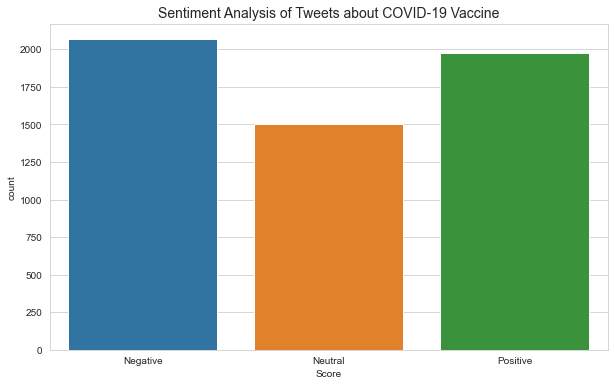

In [21]:
# plot as bar graph
plt.figure(figsize= (10, 6))
sns.countplot(data= sentiment_partial, x = 'Google Sentiment')
plt.title('Sentiment Analysis of Tweets about COVID-19 Vaccine', fontsize = 14)
plt.xlabel('Score')
plt.show()

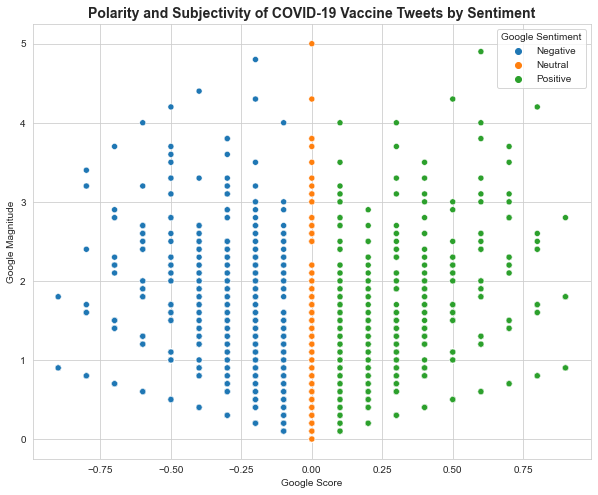

In [22]:
# plot polarity and subjectivity and sentiment of the Tweet
plt.figure(figsize= (10,8))
sns.scatterplot(x= 'Google Score', y= 'Google Magnitude', data= sentiment_partial, hue= 'Google Sentiment')
plt.title('Polarity and Subjectivity of COVID-19 Vaccine Tweets by Sentiment', 
          fontsize = 14, fontweight= 'bold')
plt.show()

In [23]:
# save to csv file
sentiment_partial.to_csv('data/tweets_google_sentiment.csv', index= False)

In [ ]:
sent1 = sentiment_df[:500]

In [ ]:
google_sent = sent1.tweets.apply(getGoogleSentiments)

In [ ]:
sent1

In [ ]:
def getMoreGoogleSentiments(txt):
    document = nlp_client.document_from_text(txt)
    
    sent_analysis = document.analyze_sentiment()
    sentiment = sent_analysis.sentiment
    
    score = sentiment.score
    scores.extendnd(score)
    magnitude = sentiment.magnitude
    magnitudes.extend(magnitude)

In [ ]:
sent2 = sentiment_df[500:1000]

In [ ]:
google_sent = sent2.tweets.apply(getMoreGoogleSentiments)

### Sentiment Analysis with TextBlob

In [ ]:
sentiment_df = pd.read_csv('data/tweets_translated.csv')

In [ ]:
# functions to clean tweets, get subjectivity and polarity scores and sentiment
def cleanTweet(txt):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(amp)", 
                           " ", str(txt)).split())

def getTextSubjectivity(txt):
    '''Subjective sentences generally refer to personal opinion, emotion 
    or judgment whereas objective refers to factual information. 
    Subjectivity is also a float which lies in the range of [0,1].'''
    return TextBlob(txt).sentiment.subjectivity

def getTextPolarity(txt):
    '''Polarity is float which lies in the range of [-1,1] 
    where 1 means positive statement and -1 means a negative statement.'''
    return TextBlob(txt).sentiment.polarity

In [ ]:
# apply functions to tweets
sentiment_df['tweets'] = sentiment_df['tweets'].apply(clean_tweet)
sentiment_df['TB Subjectivity'] = sentiment_df['tweets'].apply(getTextSubjectivity)
sentiment_df['TB Polarity'] = sentiment_df['tweets'].apply(getTextPolarity)
sentiment_df['TB Sentiment'] = sentiment_df['TB Polarity'].apply(getTextAnalysis)
sentiment_df

In [ ]:
# plot as bar graph
plt.figure(figsize= (10, 6))
sns.countplot(data= sentiment_df, x = 'TB Sentiment')
plt.title('Sentiment Analysis of Tweets about COVID-19 Vaccine', fontsize = 14)
plt.xlabel('Score')
plt.show()

In [ ]:
# plot polarity and subjectivity and sentiment of the Tweet
plt.figure(figsize= (10,8))
sns.scatterplot(x= 'TB Polarity', y= 'TB Subjectivity', data= sentiment_df, hue= 'TB Sentiment')
plt.title('Polarity and Subjectivity of COVID-19 Vaccine Tweets by Sentiment', 
          fontsize = 14, fontweight= 'bold')
plt.show()

In [ ]:
# save all to csv
# sentiment_df.to_csv('data/tweets_sentiment_data.csv', index= False)

### Word Cloud, Word Freqency and Bigram

In [ ]:
# create word cloud
words = ' '.join([tweet for tweet in sentiment_df['tweets']])
wc = WordCloud(background_color= '#222222').generate(words)
plt.figure(figsize= (10, 6))
plt.imshow(wc.recolor(colormap= 'spring'))
plt.axis('off')
plt.title('COVID-19 Vaccine Word Cloud')
plt.show()

In [ ]:
# tokenizing
tokens = dataf['tweets'].map(word_tokenize)
tokens

In [ ]:
# create stopwords list
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

In [ ]:
 # remove stop words make make all words lowercase
stopped_data = [w.lower() for l in tokens for w in l if w not in stopwords_list]
print(len(stopped_data))
stopped_data

In [ ]:
# show 20 most common words
words_freq = FreqDist(stopped_data)
freq_words_20 = words_freq.most_common(20)

In [ ]:
# plot 20 most frequent words


In [ ]:
#bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()

tweets_finder = nltk.collocations.BigramCollocationFinder.from_words(stopped_data)

tweets_scored = tweets_finder.score_ngrams(bigram_measures.raw_freq)
tweets_scored[:10]

### Differences from Google and TextBlob

## Classification Modeling
---
Time to vectorize and build some models!

In [ ]:
data = pd.read_csv('data/tweets_sentiment_data.csv')

In [ ]:
# create lists of only tweets or labels, convert tweets to unicode
X = data['tweets'].astype('U')
y = data['Google Sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [ ]:
# use TweetTokenizer and TF IDF Vectorizer
def tokenize(tweet):
    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
    return tknzr.tokenize(tweet)

tfidf_vect = TfidfVectorizer(stop_words= 'english', tokenizer= tokenize)

In [ ]:
tfidf_Xtrain = tfidf_vect.fit_transform(X_train)
tfidf_Xtest = tfidf_vect.transform(X_test)

In [ ]:
print('Xtest shape:', tfidf_Xtest.shape)
print('Xtrain shape:', tfidf_Xtrain.shape)

### Building Models

In [ ]:
# import necessary libraries for modeling
from sklearn.metrics import f1_score, accuracy_score, classification_report,\
confusion_matrix, roc_auc_score, plot_confusion_matrix, plot_roc_curve

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [ ]:
# instantiate classifiers for vanilla models
classifiers = {
    'Logistic Regression' : LogisticRegression(max_iter=200), 
    'Random Forest' : RandomForestClassifier(), 
    'Support Vector Machine' : SVC(), 
    'XGBoost' : XGBClassifier(), 
    'Naive Bayes' : MultinomialNB()
}

In [ ]:
# create DataFrame to hold results from vanilla models
# takes approx 2 mins to run
results = pd.DataFrame(columns= ['Train_accuracy', 'Test_accuracy', 
                                 'Macro_F1_score', 'Weighted_F1_score'])

# predict, get accuracy and f1 scores and add to dataframe
conf_matrices = []
for key, value in classifiers.items():
    # fit models
    value.fit(tfidf_Xtrain, y_train)
    train_pred = value.predict(tfidf_Xtrain)
    y_pred = value.predict(tfidf_Xtest)
    
    # get accuracy, f1 score
    train_acc = accuracy_score(y_train, train_pred) * 100
    test_acc = accuracy_score(y_test, y_pred) * 100
    macro_f1 = f1_score(y_test, y_pred, average= 'macro')
    weight_f1 = f1_score(y_test, y_pred, average= 'weighted')
    
    # get false neg and true positive
    # add to confusion matrices list to view later if desired
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)
    
    # add measurements to datafram
    results.loc[key] = [round(train_acc, 2), round(test_acc, 2), 
                        round(macro_f1, 2), round(weight_f1, 2)]

In [ ]:
results.sort_values(by= ['Test_accuracy', 'Weighted_F1_score'], ascending= False)

Naive Bayes performed the worst while XGBoost performed the best with the least amount of overfitting. 

Next, let's tune some hyperparameters and see if we can get better results.

#### Hyperparameter Tuning

In [83]:
# function to get results after each model

def get_results(model, model_name):
    train_pred = model.predict(tfidf_Xtrain)
    y_pred = model.predict(tfidf_Xtest)
    
    # get classification report
    print('{} Classification Report'.format(model_name))
    print(classification_report(y_test, y_pred))
    
    # get confusion matrix
    plot_confusion_matrix(model, tfidf_Xtest, y_test, cmap= "Blues", 
                          values_format= '.5g')
    plt.grid(False)
    plt.title('{} Confusion Matrix'.format(model_name))
    plt.show()
    
    # get accuracy and F1 scores
    train_acc = accuracy_score(y_train, train_pred) * 100
    test_acc = accuracy_score(y_test, y_pred) * 100
    macro_f1 = f1_score(y_test, y_pred, average= 'macro')
    weight_f1 = f1_score(y_test, y_pred, average= 'weighted')
    
    #get false neg and true positive
    cm = confusion_matrix(y_test, y_pred)
    
    # save measurements into results df
    results.loc[model_name] = [round(train_acc, 2), round(test_acc, 2), 
                               round(macro_f1, 2), round(weight_f1, 2)]

**XGBoost**

In [67]:
# set up hyperparameter grid
param_grid_xgb = {
    'learning_rate' : [0.05, 0.08, 0.1, 0.2],
    'max_depth' : [3, 4, 6, 8], 
    'min_child_weight' : [1, 2, 3]
}

In [69]:
# instantiate classifer, fit on model through randomized search
xgb = XGBClassifier(objective= 'softmax')
RS_xgb = RandomizedSearchCV(xgb, param_grid_xgb, scoring= 'f1_weighted', random_state= 27)
RS_xgb.fit(tfidf_Xtrain, y_train)

In [70]:
RS_xgb.fit(tfidf_Xtrain, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [71]:
RS_xgb.best_params_

{'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.2}

RS XGBoost Classification Report
              precision    recall  f1-score   support

    Negative       0.79      0.49      0.61       644
     Neutral       0.73      0.86      0.79      1205
    Positive       0.81      0.82      0.81      1866

    accuracy                           0.78      3715
   macro avg       0.78      0.72      0.74      3715
weighted avg       0.78      0.78      0.77      3715



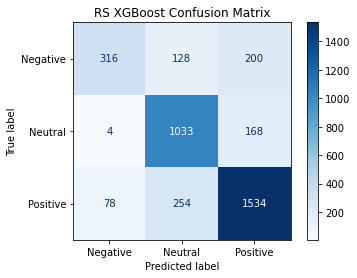

In [84]:
get_results(RS_xgb, 'RS XGBoost')

In [ ]:
# original confusion matrix that was not tuned
conf_matrices[3]

**Random Forest**

In [87]:
param_grid_rf = {
    'n_estimators' : [100, 150], 
    'max_depth' : [100, 120], 
    'min_samples_split' : [2, 4, 8], 
    'min_samples_leaf' : [3, 5]
}

In [88]:
rf = RandomForestClassifier()
RS_rf = RandomizedSearchCV(rf, param_grid_rf, n_iter= 20, scoring= 'f1_weighted', 
                          random_state= 27)
RS_rf.fit(tfidf_Xtrain, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [80, 100, 120],
                                        'min_samples_leaf': [3, 5, 7],
                                        'min_samples_split': [2, 4, 8],
                                        'n_estimators': [100, 150, 200]},
                   random_state=27, scoring='accuracy')

In [90]:
RS_rf.best_params_

{'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 5,
 'max_depth': 120}

RS Random Forest Classification Report
              precision    recall  f1-score   support

    Negative       0.93      0.20      0.33       644
     Neutral       0.74      0.65      0.69      1205
    Positive       0.67      0.90      0.77      1866

    accuracy                           0.70      3715
   macro avg       0.78      0.58      0.60      3715
weighted avg       0.74      0.70      0.67      3715



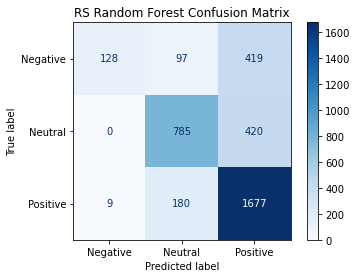

In [91]:
get_results(RS_rf, 'RS Random Forest')

**Support Vector Machines**

In [93]:
param_grid_svc = {
    'kernel': ['rbf'], 
    'gamma': ['scale', 1e-3, 1e-4, 1e-5],
    'C': [1, 10, 100]
}

In [ ]:
svc = SVC()
RS_svc = RandomizedSearchCV(svc, param_grid_svc, scoring= 'f1_weighted')
RS_svc.fit(tfidf_Xtrain, y_train)

In [ ]:
RS_svc.best_params_

In [ ]:
get_results(RS_svc, 'RS Support VM')

**Logistic Regression**

In [ ]:
param_grid_lg = {
    'penalty' : ['l1', 'l2'], 
    'C': [0.05, 0.1, 1], 
    'class_weight' : [None, 'balanced']
    'random_state' : [27]
}

In [ ]:
lg = LogisticRegression()
GS_lg = GridSearchCV(lg, param_grid_lg, scoring= 'f1_weighted')
GS_lg.fit(tfidf_Xtrain, y_train)

In [ ]:
GS_lg.best_params_

In [ ]:
get_results(GS_lg, 'GS Logistic Regression')